In [1]:
import os
import natsort
from pathlib import Path
import re
import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchNDF
from torchNDF.data.pandas_utils import *

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [541]:
PATH = Path('../../data/final').resolve()
all_currencies = pd.read_pickle(f'{PATH}/ndf_oanda_spots')

## In this notebook:

* Augmentation of NDF spot rates with ARIMA 1-step forecasts
* Augmentation with technical indicators (all currencies)
* Return calculation for different tenors

# ARIMA as a feature

Add 1 step ARIMA forecasts for NDF currencies as features

In [542]:
all_currencies = all_currencies.loc[:, ~all_currencies.columns.duplicated()]
all_currencies.drop(columns=['USDCNH'], inplace=True)

We use 10% of the data as training observations for the ARIMA model

In [ ]:
augment_with_arima_features(all_currencies)

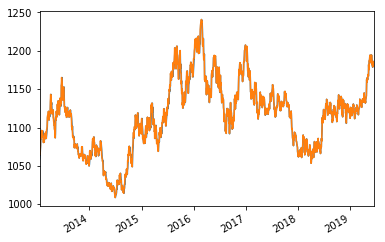

In [548]:
all_currencies['USDKRW'].plot()
all_currencies['ARIMA_USDKRW'].plot()

# Technical indicators: MA, MACD, EMW

In [549]:
all_currencies.columns[:65]

Index(['USDKRW', 'USDTWD', 'USDMYR', 'USDIDR', 'USDPHP', 'USDCNY', 'USDINR',
       'USDZAR', 'CHFZAR', 'EURHUF', 'USDCHF', 'EURNZD', 'SGDJPY', 'GBPAUD',
       'EURZAR', 'GBPPLN', 'GBPSGD', 'EURSGD', 'EURDKK', 'USDJPY', 'EURUSD',
       'GBPZAR', 'EURSEK', 'EURGBP', 'USDSAR', 'CADJPY', 'GBPNZD', 'USDSGD',
       'AUDNZD', 'EURNOK', 'USDHUF', 'GBPCHF', 'AUDUSD', 'GBPUSD', 'EURCZK',
       'TRYJPY', 'EURCHF', 'USDHKD', 'NZDCAD', 'USDPLN', 'CHFJPY', 'USDCAD',
       'EURJPY', 'USDTRY', 'EURTRY', 'USDSEK', 'USDCZK', 'CADCHF', 'USDTHB',
       'EURAUD', 'USDMXN', 'GBPJPY', 'AUDJPY', 'ZARJPY', 'NZDUSD', 'AUDCAD',
       'GBPCAD', 'USDDKK', 'CADSGD', 'EURCAD', 'USDNOK', 'EURPLN', 'NZDSGD',
       'AUDSGD', 'NZDJPY'],
      dtype='object')

In [550]:
orig = all_currencies

In [552]:
augment_with_technical_indicators(all_currencies, column_idx=65)

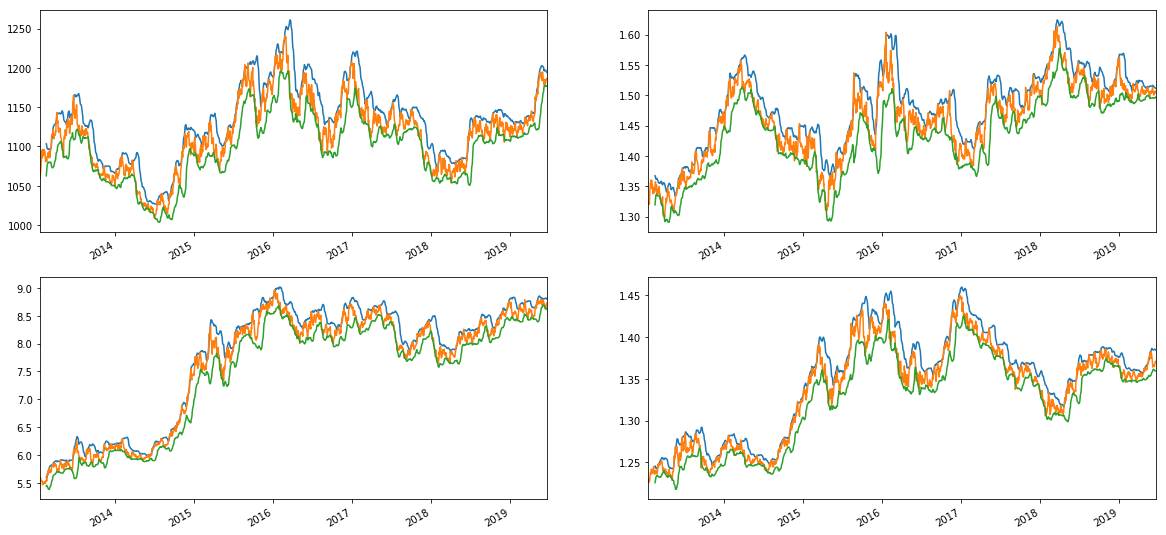

In [553]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
all_currencies['USDKRW_upper_band'].plot()
all_currencies['USDKRW'].plot()
all_currencies['USDKRW_lower_band'].plot()
plt.subplot(2,2,2)
all_currencies['EURCAD_upper_band'].plot()
all_currencies['EURCAD'].plot()
all_currencies['EURCAD_lower_band'].plot()
plt.subplot(2,2,3)
all_currencies['USDNOK_upper_band'].plot()
all_currencies['USDNOK'].plot()
all_currencies['USDNOK_lower_band'].plot()
plt.subplot(2,2,4)
all_currencies['USDSGD_upper_band'].plot()
all_currencies['USDSGD'].plot()
all_currencies['USDSGD_lower_band'].plot();

In [554]:
# rolling normalization: since we have to drop the first 165 rows due to them
# being part of the ARIMA training set, use them for rolling norm first
# input sequence length will be 30, thus normalizing window should be
# a multiple of 30
all_currencies = (all_currencies - all_currencies.rolling(120).mean())/all_currencies.rolling(120).std()
# drop first 165 rows (avoid leakage from ARIMA forecast training)
all_currencies = all_currencies.iloc[165:,:]

# Save

In [560]:
PATH = Path('../../data/final').resolve()
orig = orig[165:]
pd.to_pickle(all_currencies, f'{PATH}/ndf_oanda_spots_technical_normalized')
pd.to_pickle(orig, f'{PATH}/ndf_oanda_spots_technical_not_normalized')

## Computing returns for different tenors

In [322]:
PATH = os.path.realpath('../../data/final')
spots_no_weekends = pd.read_pickle('{}/ndf_spots'.format(PATH))

In [323]:
# align with input data 
# recall we dropped first 165 rows used for training ARIMA models
spots_no_weekends = spots_no_weekends[165:]

# stretch spots by including weekends
spots_weekends = as_dateindex_filled(spots_no_weekends)

# natsort and drop MYR and CNH
spots_no_weekends.drop(columns=['USDMYR', 'USDCNH'], inplace=True)
spots_weekends.drop(columns=['USDMYR_ff', 'USDCNH_ff'], inplace=True)
spots_no_weekends = spots_no_weekends.reindex(columns=natsort.natsorted(spots_no_weekends.columns))
spots_weekends = spots_weekends.reindex(columns=natsort.natsorted(spots_weekends.columns))      

# rename _ff
renaming_dict = dict(zip(spots_weekends.columns, spots_no_weekends.columns))
spots_weekends.rename(columns=renaming_dict, inplace=True)

In [326]:
spots_no_weekends.index = pd.to_datetime(spots_no_weekends.index)
spots_weekends.index = pd.to_datetime(spots_weekends.index)

returns = []
for i in range(0, 91):
    returns.append(n_step_returns(spots_no_weekends, spots_weekends, i))

In [333]:
# 90 day tenor returns are the shortest element in returns: 
# shorten all the other entries to match
returns = [x[:1424,:] for x in returns]

# concatenate into a single np.array
returns = np.concatenate([np.expand_dims(x, 0) for x in returns], axis=0)

In [338]:
# each of the 91 elements in `returns` contains daily returns (1489)
# for each of the 6 NDF currencies in natsorted order
# e.g to obtain 10 day tenor returns at day 100 for USDKRW, indexing is [11,100,3]
returns.shape

(91, 1424, 6)

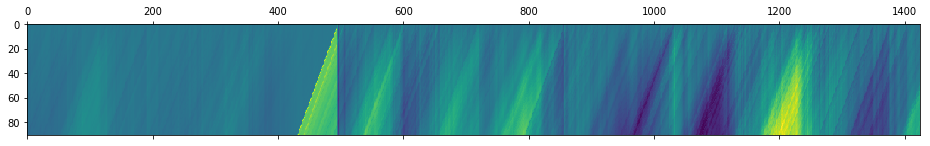

In [345]:
plt.matshow(returns[:,:,0], aspect='auto')

## Save

In [368]:
PATH = Path('../../data/final').resolve()
pd.to_pickle(returns, f'{PATH}/returns')